In [1]:
import os
from io import BytesIO, StringIO
from pathlib import Path

import boto3
import botocore.exceptions
import numpy as np
import pandas as pd
from dotenv import load_dotenv

In [2]:
PROJ_ROOT = Path.cwd().parent

In [3]:
assert load_dotenv(dotenv_path=PROJ_ROOT.parent / '.env')

In [68]:
import cc_churn.costs as costs
import cc_churn.visualization as vzu

In [62]:
# R2 data bucket details
bucket_name = 'cc-churn-splits'
# # name of validation data with predictions key (file) in private R2 bucket
r2_key_val_partial = 'validation_predictions__logisticregression__'
# # name of validation data with predictions key (file) in private R2 bucket
r2_key_test_partial = 'test_predictions__logisticregression__'

# columns to load
columns = [
    'clientnum',
    'card_category',
    'total_revolv_bal',
    'total_trans_amt',
    'y_pred_proba',
    'y_pred',
    'is_churned',
]

# costs
# # revenue from transactions (bank earns #% of transaction volume)
interchange_rate = 0.02
# # revenue from revolving balance (~20% interest)
apr = 0.18
# # fee revenue from credit card exposure (modeled from card type)
card_fees = {"Blue": 0, "Silver": 50, "Gold": 100, "Platinum": 200}
tenure_years = 3
discount = 0.9
# # percentage of churners who can be convinced to stay (i.e. success rate
# # of saving a churning customer)
success_rate = 0.40
# # cost of intervention to get a single customer to not churn (discounts,
# # call center time, retention offers, etc.)
intervention_cost = 50

In [59]:
account_id = os.getenv('ACCOUNT_ID')
access_key_id = os.getenv('ACCESS_KEY_ID')
secret_access_key = os.getenv('SECRET_ACCESS_KEY')

s3_client = boto3.client(
    's3',
    endpoint_url=f'https://{account_id}.r2.cloudflarestorage.com',
    aws_access_key_id=access_key_id,
    aws_secret_access_key=secret_access_key,
    region_name='auto'
)

# costs
multiplier = (1 - discount**tenure_years) / (1 - discount)

In [52]:
def pandas_read_parquet_r2(bucket_name, r2_key, columns):
    """Read parquet file from private R2 bucket."""
    s3_object = s3_client.get_object(Bucket=bucket_name, Key=r2_key)
    df = pd.read_parquet(
        BytesIO(s3_object['Body'].read()),
        columns=columns,
        dtype_backend='pyarrow',
    )
    return df


def pandas_read_filtered_parquets_r2(bucket_name, key_prefix, cols_to_load):
    """Read parquet files using partial filename from private R2 bucket."""
    s3_objects = s3_client.list_objects_v2(
        Bucket=bucket_name, Prefix=key_prefix, MaxKeys=1
    )
    assert s3_objects['ResponseMetadata']['HTTPStatusCode'] == 200
    df = pd.concat(
        [
            pandas_read_parquet_r2(
                bucket_name, obj['Key'], columns=cols_to_load
            )
            for obj in s3_objects['Contents']
        ],
        ignore_index=True,
    )
    return df


def export_df_to_r2(df, bucket_name, r2_key):
    """Export DataFrame to file in private R2 bucket, if not present."""
    try:
        s3_client.head_object(Bucket=bucket_name, Key=r2_key)
        print(f"Key {r2_key} already exists in bucket {bucket_name}")
    except botocore.exceptions.ClientError as e:
        if e.response["Error"]["Code"] == "404":
            print(f"Key {r2_key} does not exist in bucket {bucket_name}")
            buffer = BytesIO()
            df.to_parquet(
                buffer,
                index=False,
                engine='pyarrow',
                compression='gzip',
            )
            response = s3_client.put_object(
                Bucket=bucket_name, Key=r2_key, Body=buffer.getvalue()
            )
            assert response['ResponseMetadata']['HTTPStatusCode'] == 200
            print(f"Exported {len(df):,} rows to key: {r2_key}")
        elif e.response["Error"]["Code"] == "403":
            print(f"Access denied to bucket {bucket_name} or key {r2_key}")
        else:
            print(f"An unexpected error occurred: {e}")

## Load Data with Predictions

In [60]:
best_estimator_threshold = 0.5

Load validation data with predictions

In [63]:
%%time
df_val_pred = pandas_read_filtered_parquets_r2(
    bucket_name, r2_key_val_partial, columns
)
print(f"Got {len(df_val_pred):,} rows of validation split predictions")
with pd.option_context('display.max_columns', None):
    display(df_val_pred)

Got 1,427 rows of validation split predictions


,clientnum,card_category,total_revolv_bal,total_trans_amt,y_pred_proba,y_pred,is_churned
0,816086508,Blue,0.0,4624.0,0.565682,1,0
1,715749858,Blue,1380.0,1723.0,0.56938,1,0
2,795991758,Blue,660.0,4079.0,0.273788,0,0
3,771594783,Blue,0.0,2264.0,0.989876,1,1
4,771502383,Blue,1539.0,4884.0,0.311991,0,0
...,...,...,...,...,...,...,...
1422,713366583,Blue,1685.0,1405.0,0.295411,0,0
1423,789684258,Silver,1847.0,7842.0,0.795347,1,1
1424,714115533,Blue,1789.0,2591.0,0.020326,0,0
1425,767574108,Blue,786.0,4094.0,0.26742,0,0


CPU times: user 52.2 ms, sys: 3.09 ms, total: 55.3 ms
Wall time: 499 ms


Load test data with predictions

In [64]:
%%time
df_test_pred = pandas_read_filtered_parquets_r2(
    bucket_name, r2_key_test_partial, columns
)
print(f"Got {len(df_test_pred):,} rows of test split predictions")
with pd.option_context('display.max_columns', None):
    display(df_test_pred)

Got 1,718 rows of test split predictions


,clientnum,card_category,total_revolv_bal,total_trans_amt,y_pred_proba,y_pred,is_churned
0,721418133,Blue,972.0,4535.0,0.028622,0,0
1,719513733,Blue,0.0,4276.0,0.495681,0,0
2,721043058,Blue,2149.0,1700.0,0.042856,0,0
3,718435158,Blue,0.0,1930.0,0.82207,1,0
4,711336033,Blue,1032.0,4080.0,0.151568,0,0
...,...,...,...,...,...,...,...
1713,719674533,Blue,1527.0,4040.0,0.017024,0,0
1714,757024233,Blue,2152.0,2555.0,0.093265,0,0
1715,710784333,Blue,1314.0,1644.0,0.681264,1,0
1716,795613233,Blue,1494.0,4949.0,0.008574,0,0


CPU times: user 19.4 ms, sys: 1.03 ms, total: 20.4 ms
Wall time: 248 ms


## Model Validation

Calculate the true savings, expected (predicted) savings and error in predicted savings (cost) using the validation data

In [65]:
%%time
df_costs_val, _, _ = costs.get_cost(
    df_val_pred,
    best_estimator_threshold,
    interchange_rate,
    apr,
    card_fees,
    multiplier,
    success_rate,
    intervention_cost,
)
with pd.option_context('display.max_columns', None):
    display(df_costs_val)

,clientnum,card_category,total_revolv_bal,total_trans_amt,y_pred_proba,y_pred,is_churned,interchange_rev,interest_rev,fee_rev,annual_rev,clv,success_rate,expected_savings,true_savings,cum_pred_savings,cum_true_savings,n,random_savings,lift,lift_ml,total_intervention_cost,ROI,ROI_pred,ROI_error,ROI_percent,ROI_percent_pred
0,713980383,Blue,0.0,1902.0,0.998646,1,1,38.04,0.0,0,38.04,103.0884,0.4,-8.820477,-8,-8.820477,-8,1,33.128866,-41.128866,-41.949343,50,-0.160000,-0.17641,-10.255957,-16.000000,-17.640953
1,752604633,Blue,0.0,761.0,0.997844,1,1,15.22,0.0,0,15.22,41.2462,0.4,-33.537085,-33,-42.357561,-41,2,66.257732,-107.257732,-108.615293,100,-0.410000,-0.423576,-3.311126,-41.000000,-42.357561
2,710586483,Blue,0.0,968.0,0.997642,1,1,19.36,0.0,0,19.36,52.4656,0.4,-29.063245,-29,-71.420807,-70,3,99.386598,-169.386598,-170.807405,150,-0.466667,-0.476139,-2.029724,-46.666667,-47.613871
3,711357858,Blue,0.0,777.0,0.997512,1,1,15.54,0.0,0,15.54,42.1134,0.4,-33.196543,-33,-104.61735,-103,4,132.515464,-235.515464,-237.132814,200,-0.515000,-0.523087,-1.570243,-51.500000,-52.308675
4,712551258,Blue,0.0,847.0,0.997101,1,1,16.94,0.0,0,16.94,45.9074,0.4,-31.690266,-31,-136.307616,-134,5,165.644330,-299.644330,-301.951945,250,-0.536000,-0.54523,-1.722101,-53.600000,-54.523046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,715530258,Blue,2517.0,2353.0,0.510098,1,1,47.06,453.06,0,500.12,1355.3252,0.4,226.539718,492,44004.70881,13054,384,12721.484536,332.515464,31283.224274,19200,0.679896,2.291912,-237.097509,67.989583,229.191192
384,709385133,Blue,1513.0,15572.0,0.507603,1,0,311.44,272.34,0,583.78,1582.0438,0.4,271.219943,-50,44275.928753,13004,385,12754.613402,249.386598,31521.315351,19250,0.675532,2.300048,-240.479304,67.553247,230.004825
385,717998058,Blue,2019.0,2644.0,0.505672,1,0,52.88,363.42,0,416.3,1128.173,0.4,178.194407,-50,44454.12316,12954,386,12787.742268,166.257732,31666.380892,19300,0.671192,2.303322,-243.169084,67.119171,230.332244
386,709779258,Blue,0.0,4075.0,0.503756,1,0,81.5,0.0,0,81.5,220.865,0.4,-5.495135,-50,44448.628025,12904,387,12820.871134,83.128866,31627.756891,19350,0.666873,2.297087,-244.4562,66.687339,229.708672


CPU times: user 27.8 ms, sys: 2.93 ms, total: 30.7 ms
Wall time: 32.6 ms


**Notes**

1. The following columns are related to the business costs and are discussed in the [project scoping document](https://github.com/edesz/credit-card-churn/blob/main/references/01_proposal.md)
   - `interchange_rev`
   - `interest_rev`
   - `fee_rev`
   - `annual_rev`
   - `clv`
   - `success_rate`
   - `expected_savings`
   - `true_savings`
   - `cum_pred_savings`
   - `cum_true_savings`
   - `n`
   - `total_intervention_cost`
   - `ROI`
   - `ROI_pred`
   - `ROI_error`
   - `ROI_percent`
   - `ROI_percent_pred`
2. The costs are only calculated for customers that are predicted to churn since these are the customers that will be targeted. For this reason, there are fewer rows in the costs `DataFrame` (`df_costs_val`) than in the `DataFrame` with the ML model predictions for the validation data (`df_val_pred`).

### Use True ROI to Get Optimal Number of Customers to Target (`N`)

Find the optimal number of customers to target in order to true predicted ROI, using the costs from the validation data

In [67]:
df_costs_optimal = (
    df_costs_val
    .query("total_intervention_cost > 0")
    .sort_values(
        by=['ROI', 'ROI_error', 'n'], ascending=[False, True, True],
        # by=['ROI', 'n'], ascending=[False, True],
        ignore_index=True,
    )
    .head(1)
)
optimal_N_roi = df_costs_optimal['n'].squeeze()
cols_costs = [
    'n',
    'cum_true_savings',
    'cum_pred_savings',
    'ROI_error',
    'ROI_percent',
    'ROI_percent_pred',
]
(
    df_costs_optimal[cols_costs]
    .style
    .set_properties(
        subset=['ROI_error', 'ROI_percent_pred'],
        **{'background-color': 'yellow', 'color': 'black'}
    )
)

,n,cum_true_savings,cum_pred_savings,ROI_error,ROI_percent,ROI_percent_pred
0,191,10995,16835.076948,-53.115752,115.130890,176.283528


**Observations**

1. In order to maximize true ROI, the optimal number of customers to target is 191. If 191 customers from the validation data are targeted, then the
   - predicted savings is approximately $16,835
     - with a more performant ML model, this value should be close to the true savings
   - predicted ROI is approximately 176%
   - error in the predicted ROI is approximately -53.12%
     - with a more performant ML model, this error should be reduced

Plot true and predicted expected savings and ROI curves to visualize the following

1. true ROI
2. predicted ROI
3. optimal number of customers based on true ROI

using the validation data

CPU times: user 16.2 ms, sys: 1.01 ms, total: 17.2 ms
Wall time: 17 ms


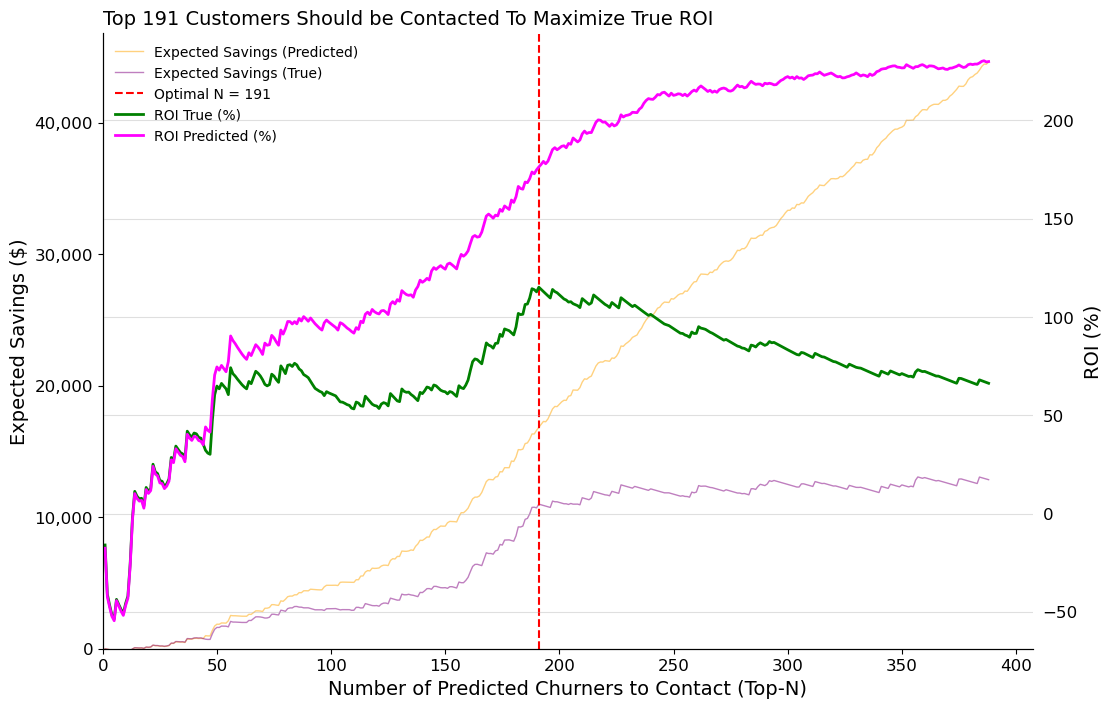

In [72]:
%%time
vzu.plot_roi_curves(
    df_costs_val['n'],
    df_costs_val['cum_true_savings'],
    df_costs_val['cum_pred_savings'],
    df_costs_val['ROI_percent'],
    df_costs_val['ROI_percent_pred'],
    {f'Optimal N = {optimal_N_roi}': {'x': optimal_N_roi, 'colour': 'red'}},
    ptitle=(
        f'Top {optimal_N_roi:,} Customers Should be Contacted To Maximize '
        'True ROI'
    ),
    legend_loc='upper left',
    xlabel=f"Number of Predicted Churners to Contact (Top-N)",
    fig_size=(12, 8),
)

**Observations**

1. This chart confirms that 191 is indeed the optimal number of customers in order to maximize true ROI (see the green curve). After contacting 191 customers, the true ROI begins to decrease.
2. The ROI predicted from the ML model (thick magenta line) is close to the true ROI up to approximately 50 customers. After this, the true and predicted ROI curves diverge and the error in predicted ROI becomes larger as more customers are targeted. This is due to the performance of the best ML model at accurately predicting true positives. With a more performant model, the gap between the magenta and green ROI curves will be smaller (better).

### Use True Lift to Get Optimal Number of Customers to Target (`N`)

Find the optimal number of customers to target in order to true incremental lift, using the costs from the validation data

In [73]:
optimal_row = df_costs_val.loc[df_costs_val["lift"].idxmax()]
optimal_N = optimal_row["n"].squeeze()

optimal_row_ml = df_costs_val.loc[df_costs_val["lift_ml"].idxmax()]
optimal_N_ml = optimal_row_ml["n"].squeeze()

(
    df_costs_val
    .assign(lift_error=lambda df: 100*(df['lift']-df['lift_ml'])/df['lift'])
    .sort_values(
        by=['lift', 'lift_error', 'n'], ascending=[False, True, True],
        ignore_index=True,
    )
    [['n', "lift", 'lift_error']]
    .head(1)
)

,n,lift,lift_error
0,227,4939.747423,-213.772078


Plot lift curves for true and predicted values versus random targeting (which assumes linear growth in savings)

CPU times: user 12.4 ms, sys: 1.02 ms, total: 13.4 ms
Wall time: 13.1 ms


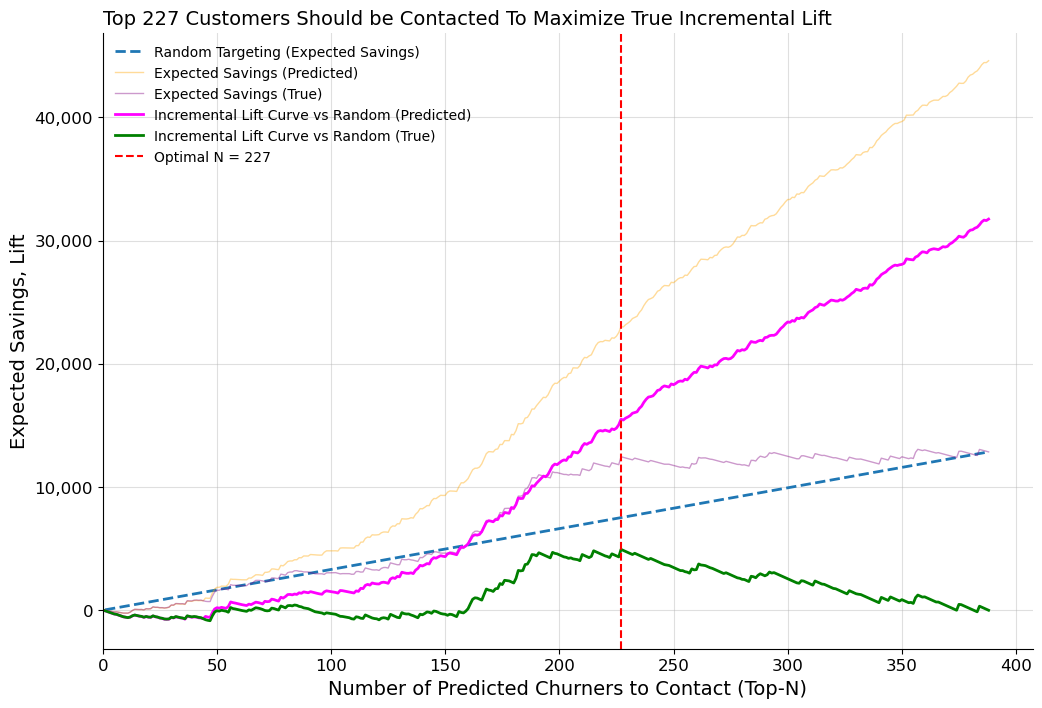

In [75]:
%%time
vzu.plot_lift_curves(
    df_costs_val['n'],
    df_costs_val['cum_true_savings'],
    df_costs_val['cum_pred_savings'],
    df_costs_val['random_savings'],
    df_costs_val['lift'],
    df_costs_val['lift_ml'],
    {f'Optimal N = {optimal_N}': {'x': optimal_N, 'colour': 'red'}},
    ptitle=(
        f'Top {optimal_N:,} Customers Should be Contacted To Maximize '
        'True Incremental Lift'
    ),
    xlabel=f"Number of Predicted Churners to Contact (Top-N)",
    fig_size=(12, 8),
)

**Observations**

1. There is a (local maximum) peak at the same number of customers found from ROI (approximately 191). As seen with the ROI curve, the lift drops and then increases again. However, unlike ROI, this subsequent increase takes the lift to a global maximum at 227 customers. Since the difference between lift using 191 customers and lift using 227 customers is minimal, we should target 191 customers since it is smaller and more cost effective.
2. Similar to ROI, the error in predicted lift grows after approximately 60 customers. As mentioned there, this gap will be smaller with a more performant ML model.

### Conclusions from Model Validation

1. The client can use the ROI to evaluate model effectiveness. This is a business-focused KPI. ROI provides a broader view of the financial efficiency of an entire investment, considering both costs and gains. On the other hand, lift is a comparison to random targeting and is a model-oriented KPI. So, recommendations from ROI will be used in favour of those from the incremental lift curves.
2. The top 191 customers (by prediction probability) should be contacted in order to maximize true ROI.
3. If the top 191 customers are predicted, the expected ROI is approximately 176% and the error in expected ROI is approximately -53%. When ML model performance is improved, this error will reduce. The Key Performance Indicator (KPI) that should be reported to the business user (or client, manager of credit card division at the bank) is the expected ROI.

## Model Evaluation

### Class Imbalance

Get the true and predicted class imbalance for the test data

In [76]:
%%time
df_true_pred_class_imbalance = (
    (
        df_test_pred['y_pred']
        .value_counts(normalize=True)
        .rename('predicted')
        .to_frame()
    )
    .merge(
        (
            df_test_pred['is_churned']
            .value_counts(normalize=True)
            .rename('true')
            .to_frame()
        ),
        left_index=True,
        right_index=True,
    )
)
df_true_pred_class_imbalance.index = df_true_pred_class_imbalance.index.map(
    {0: 'No Churn', 1: 'Churn'}
)
df_true_pred_class_imbalance

CPU times: user 4.95 ms, sys: 0 ns, total: 4.95 ms
Wall time: 9.19 ms


,predicted,true
y_pred,,
No Churn,0.747381,0.839348
Churn,0.252619,0.160652


**Observations**

1. The class imbalance in the test split is approximately the same as that in the training split (~84%:16%).
2. Due to the inaccuracy of the model, the class imbalance of the predictions is ~75%:25% which means ~25% instead of ~16% of customers are predicted to churn (i.e. ~25% of customers are predicted to cancel their credit card).

The class imbalance in the validation and test data is shown below

In [78]:
(
    df_val_pred['is_churned']
    .value_counts(normalize=True)
    .rename('validation')
    .to_frame()
    .merge(
        df_test_pred['is_churned'].value_counts(normalize=True).rename('test').to_frame(),
        left_index=True,
        right_index=True,
        how='left',
    )
)

,validation,test
is_churned,,
0,0.839523,0.839348
1,0.160477,0.160652


**Notes**

1. It is reassuring that the class imbalances are nearly equivalent between the validation and test splits. Patterns seen in during model validation should not be impacted by changes of the class imbalance during model evaluation.

Show the class imbalance and distribution of prediction probabilities for the test data

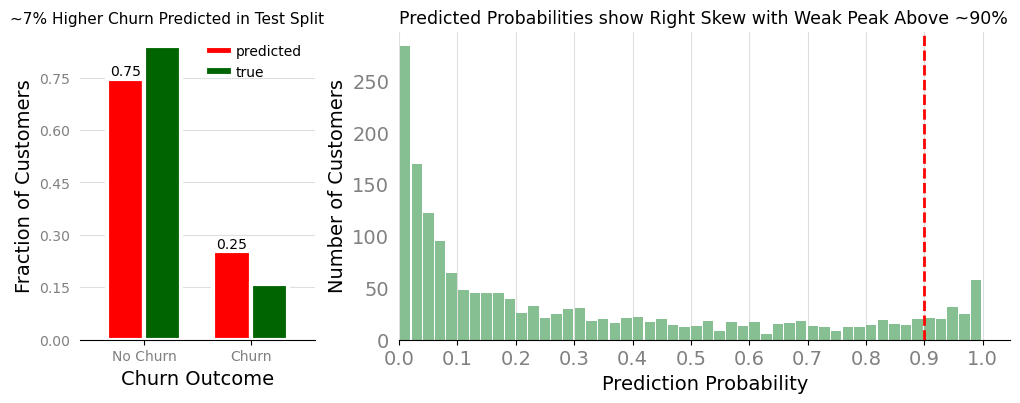

In [81]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, (ax1, ax2) = plt.subplots(
    1, 2, gridspec_kw={'width_ratios': [1.15, 3]}, figsize=(12, 4)
)

# class imbalance in true labels
ax1 = df_true_pred_class_imbalance.plot.bar(
    grid=False,
    color={"true": "darkgreen", "predicted": "Red"},
    zorder=2,
    width=0.7,
    edgecolor='white', linewidth=3,
    ax=ax1,
)
ax1.legend(frameon=False, handletextpad=0.2)
ax1.bar_label(ax1.containers[0], fmt="%.2f")
ax1.set_title(
    '~7% Higher Churn Predicted in Test Split', x=-0.3, loc='left', fontsize=11
)
ax1.set_xlabel('Churn Outcome', fontsize=14)
ax1.set_ylabel('Fraction of Customers', fontsize=14)
ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.15))
ax1.tick_params(axis="both", which="both", labelsize=10, labelcolor='grey')
ax1.tick_params(axis="y", left=False)
ax1.tick_params(axis='x', labelrotation=0)
ax1.grid(True, axis='y', alpha=0.4)
ax1.spines[['left', 'right', 'top']].set_visible(False)

# distribution of predicted probabilities
ax2 = (
    df_test_pred['y_pred_proba']
    .plot
    .hist(
        bins=50,
        grid=False,
        color='#86bf91',
        zorder=2,
        rwidth=0.9,
        ax=ax2,
    )
)
ax2.axvline(
    x=0.9, color='red', linestyle='--', linewidth=2, zorder=3
)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax2.set_title(
    'Predicted Probabilities show Right Skew with Weak Peak Above ~90%',
    loc='left',
    fontsize=12.5,
)
ax2.set_xlim(0)
ax2.tick_params(axis="both", which="both", labelsize=14, labelcolor='grey')
ax2.tick_params(axis="y", left=False)
ax2.set_ylabel('Number of Customers', fontsize=14)
ax2.set_xlabel('Prediction Probability', fontsize=14)
ax2.grid(True, axis='x', alpha=0.4)
ax2.spines[['left', 'right', 'top']].set_visible(False)

**Observations**

1. As expected from the predicted class imbalance, the distribution of predicted probabilities is right-skewed and a small fraction of customers have a predicted probability above 50%.